# Using CNN to Classify Colon Histopathological Images

**Import Necessary Libraries**

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from monai.networks.nets import EfficientNetBN
from torchinfo import summary
from tqdm import tqdm
from torch.amp import autocast, GradScaler

import cv2
from skimage.segmentation import mark_boundaries
from captum.attr import GuidedGradCam, LayerGradCam, visualization

In [3]:
# Set Device for GPU Acceleration with Nvidia cuda if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


**Define Paths and Hyperparameters**

In [4]:
# Define dataset location and essential training hyperparameters.
DATA_DIR = 'Dataset/lung_colon_image_set/colon_image_sets'
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4

**Prepare Dataframe**

In [5]:
# Function to extract file paths and corresponding labels from the dataset directory.
def prepare_dataframe(data_dir):
    filepaths, labels = [], []
    for fold in os.listdir(data_dir):
        foldpath = os.path.join(data_dir, fold)
        for file in os.listdir(foldpath):
            filepaths.append(os.path.join(foldpath, file))
            labels.append(fold)
    return pd.DataFrame({"filepaths": filepaths, "labels": labels})


df = prepare_dataframe(DATA_DIR)

In [6]:
# Split dataset into training, validation, and testing sets with an 80-10-10 ratio.
train_df, dummy_df = train_test_split(df, train_size=0.8, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, random_state=123)

# Create a dictionary mapping class labels to numerical indices.
classes = train_df["labels"].unique()
class_to_idx = {label: idx for idx, label in enumerate(classes)}

print("Classes:", classes)
print("Class to Index Mapping:", class_to_idx)


Classes: ['colon_n' 'colon_aca']
Class to Index Mapping: {'colon_n': 0, 'colon_aca': 1}


**Dataset Class**

In [7]:
# Dataset class to load images and corresponding labels.
class ColonCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_to_idx=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_to_idx = class_to_idx or {label: idx for idx, label in enumerate(dataframe['labels'].unique())}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label_idx = self.class_to_idx[label]
        return image, torch.tensor(label_idx)
    

**Define Image Transforms & Create DataLoaders**

In [9]:
# Apply preprocessing transformations for images before feeding into the model
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset instances for training, validation, and testing.
train_dataset = ColonCancerDataset(train_df, transform=transform, class_to_idx=class_to_idx)
valid_dataset = ColonCancerDataset(valid_df, transform=transform, class_to_idx=class_to_idx)
test_dataset = ColonCancerDataset(test_df, transform=transform, class_to_idx=class_to_idx)

# Load datasets into DataLoader objects for batch processing.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders created successfully.")

# Visualise a Batch of Images
# Create Dataset
dataset = ColonCancerDataset(train_df, transform=transform, class_to_idx=class_to_idx)

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)  # num_workers=0 for Windows compatibility

# Load a batch
batch = next(iter(train_loader))
images, labels = batch

# Reverse the class_to_idx mapping
index_to_label = {idx: label for label, idx in class_to_idx.items()}

# Plot the first 8 images in the batch
plt.figure(figsize=(15, 8))
for i in range(8):  # Adjust based on batch size
    plt.subplot(2, 4, i + 1)
    image = images[i].permute(1, 2, 0).numpy()  # Convert to HWC format for plotting
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Un-normalise the image
    image = np.clip(image, 0, 1)  # Clip values to valid range
    label_name = index_to_label[labels[i].item()]  # Convert label index to class name
    plt.imshow(image)
    plt.title(f"Label: {label_name}")
    plt.axis("off")
plt.tight_layout()
plt.show()


DataLoaders created successfully.


**Model Definition**

In [10]:
# Load EfficientNet model from MONAI library and modify it for classification.


def get_model(num_classes):
    """
    Initialize EfficientNetBN using a predefined model name.
    """
    model = EfficientNetBN(
        model_name="efficientnet-b3",  # Use predefined models (b0 to b7 or others)
        pretrained=True,  # Use pretrained weights
        spatial_dims=2,  # 2D model
        in_channels=3,  # Input channels (RGB)
        num_classes=num_classes  # Number of output classes
    )
    return model.to(DEVICE)


# Initialize the model
model = get_model(num_classes=len(classes))
print(model)


# Print model summary
print(summary(model, input_size=(BATCH_SIZE, 3, *IMG_SIZE)))



EfficientNetBN(
  (_conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_conv_stem_padding): ConstantPad2d(padding=(0, 1, 0, 1), value=0.0)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (_blocks): Sequential(
    (0): Sequential(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_expand_conv_padding): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), groups=40, bias=False)
        (_depthwise_conv_padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (_se_adaptpool): AdaptiveAvgPool2d(output_size=1)
        (_se_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
        (_se_reduce_padding): Identity()
        (_se_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        (_se_expand_padding): Identity()
       

**Training the model with Mixed Precision and Cosine Annealing**

In [11]:
# Define training function with mixed precision for efficiency and learning rate scheduling.

def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs):
    scaler = GradScaler(device='cuda')  # For Mixed Precision on CUDA

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for images, labels in progress_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()

            with autocast(device_type='cuda'):
  # Enable Mixed Precision
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()  # Scale the gradients
            scaler.step(optimizer)  # Step the optimizer
            scaler.update()  # Update the scaler

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            progress_bar.set_postfix(loss=loss.item(), accuracy=correct / total)

        # Step the scheduler (Cosine Annealing)
        scheduler.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {running_loss / len(train_loader):.4f}, Accuracy: {correct / total:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

**Evaluating the Model**

In [12]:
# Function to evaluate the trained model on the test dataset and generate performance metrics.
def evaluate_model(model, test_loader, classes):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=classes))

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()



**Load Trained Model**

In [13]:
# Function to load a previously trained model
def load_model(model_path, num_classes):
    model = get_model(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    print(f"Model loaded from {model_path}")
    return model

**Grad-CAM Heatmap Generation**

In [14]:
# Function to generate Grad-CAM heatmaps for interpretability.
def generate_grad_cam(model, image_path, target_layer, class_idx=None):
    """
    Generates a Grad-CAM heatmap for the given image.
    """
    model.eval()

    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # Define Grad-CAM
    grad_cam = LayerGradCam(model, target_layer)

    # Generate attributions
    attributions = grad_cam.attribute(image_tensor, target=class_idx)

    # Convert to numpy and visualise
    heatmap = visualization.visualize_image_attr(
        attributions.cpu().detach().numpy()[0], 
        image_tensor.cpu().detach().numpy()[0]
    )

    return heatmap


**Training the Model**

In [15]:
# Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Train Model with LR Scheduling
train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, NUM_EPOCHS)


Epoch 1/10: 100%|██████████| 500/500 [03:34<00:00,  2.33it/s, accuracy=0.969, loss=2.98e-8] 


Epoch [1/10] - Loss: 0.1649, Accuracy: 0.9690, LR: 0.000098


Epoch 2/10: 100%|██████████| 500/500 [02:23<00:00,  3.49it/s, accuracy=0.996, loss=1.45e-6] 


Epoch [2/10] - Loss: 0.0183, Accuracy: 0.9961, LR: 0.000091


Epoch 3/10: 100%|██████████| 500/500 [02:20<00:00,  3.56it/s, accuracy=0.998, loss=1.72e-5] 


Epoch [3/10] - Loss: 0.0057, Accuracy: 0.9981, LR: 0.000080


Epoch 4/10: 100%|██████████| 500/500 [02:21<00:00,  3.52it/s, accuracy=0.999, loss=0]       


Epoch [4/10] - Loss: 0.0051, Accuracy: 0.9988, LR: 0.000066


Epoch 5/10: 100%|██████████| 500/500 [02:18<00:00,  3.60it/s, accuracy=1, loss=0]       


Epoch [5/10] - Loss: 0.0019, Accuracy: 0.9996, LR: 0.000051


Epoch 6/10: 100%|██████████| 500/500 [02:20<00:00,  3.56it/s, accuracy=0.999, loss=0]       


Epoch [6/10] - Loss: 0.0024, Accuracy: 0.9992, LR: 0.000035


Epoch 7/10: 100%|██████████| 500/500 [02:21<00:00,  3.52it/s, accuracy=1, loss=5.69e-5]    


Epoch [7/10] - Loss: 0.0013, Accuracy: 0.9999, LR: 0.000021


Epoch 8/10: 100%|██████████| 500/500 [02:21<00:00,  3.53it/s, accuracy=1, loss=0]           


Epoch [8/10] - Loss: 0.0006, Accuracy: 0.9998, LR: 0.000010


Epoch 9/10: 100%|██████████| 500/500 [02:21<00:00,  3.53it/s, accuracy=1, loss=5.22e-8] 


Epoch [9/10] - Loss: 0.0015, Accuracy: 0.9999, LR: 0.000003


Epoch 10/10: 100%|██████████| 500/500 [02:19<00:00,  3.57it/s, accuracy=1, loss=1.49e-8] 

Epoch [10/10] - Loss: 0.0003, Accuracy: 0.9999, LR: 0.000001


**Save and Load model**

In [54]:
# Save the trained model
MODEL_PATH = "patch_model.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Model saved to patch_model.pth


Model loaded from patch_model.pth
              precision    recall  f1-score   support

     colon_n       1.00      1.00      1.00       390
   colon_aca       1.00      1.00      1.00       410

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


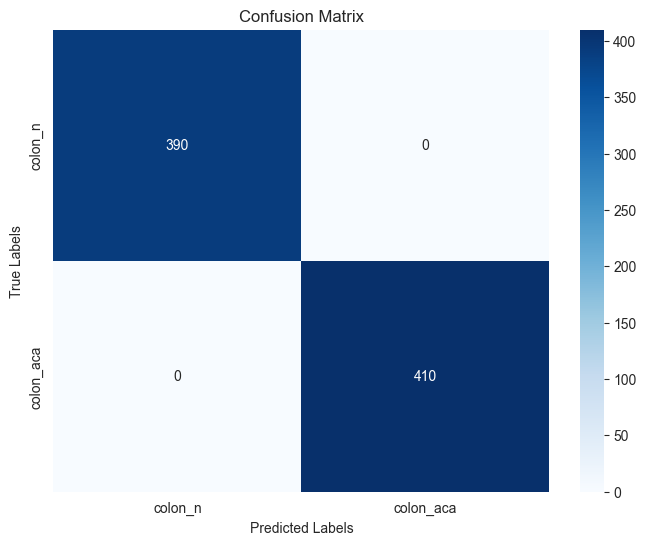

In [55]:
# Load the model and evaluate performance
model = load_model("patch_model.pth", num_classes=len(classes))
evaluate_model(model, test_loader, classes)

**Testing Model against Test split**

In [56]:
# Function to test the trained model on the test dataset and print accuracy.
def test_model_on_dataset(model, test_loader, classes):
    """
    Runs the model on the test dataset and prints accuracy.
    """
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Run test
test_model_on_dataset(model, test_loader, classes)


Test Accuracy: 100.00%


**Visualizing Model Predictions**

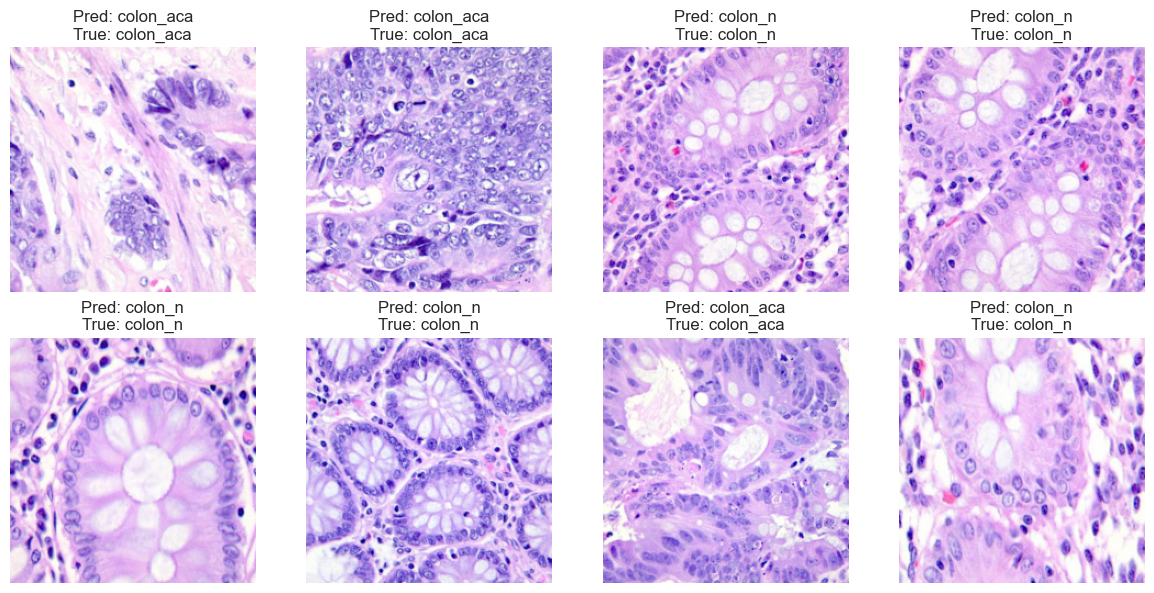

In [57]:
def plot_model_predictions(model, test_loader, classes, num_images=8):
    """
    Displays a batch of images with model predictions.
    """
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Un-normalise
        img = np.clip(img, 0, 1)

        pred_label = classes[preds[i].item()]
        true_label = classes[labels[i].item()]

        ax.imshow(img)
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization
plot_model_predictions(model, test_loader, classes)
